<a href="https://colab.research.google.com/github/skywalker0803r/works/blob/master/C10NP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import warnings 
warnings.simplefilter('ignore')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# LOAD

In [0]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

train = pd.read_csv('/content/drive/My Drive/台塑輕油案子/data/train_4521.csv',index_col=0).reset_index(drop=True)
test_250 = pd.read_csv('/content/drive/My Drive/台塑輕油案子/data/test_250.csv',index_col=0).reset_index(drop=True)
test_170 = pd.read_csv('/content/drive/My Drive/台塑輕油案子/data/test_170.csv',index_col=0).reset_index(drop=True)

In [3]:
train.head()

,T10,T50,T90,N+A,C5NP,C5IP,C5N,C6NP,C6IP,C6N,C6A,C7NP,C7IP,C7N,C7A,C8NP,C8IP,C8N,C8A,C9NP,C9IP,C9N,C9A,C10NP,C10IP,C10N,C10A
0,100.5,119.2,146.5,31.978,0.272,0.132,0.059,5.293,2.570,2.819,0.494,10.395,8.070,6.411,2.917,9.138,9.649,4.810,5.373,6.405,9.759,4.590,3.661,0.875,5.257,0.525,0.319
1,99.6,117.9,145.5,31.568,0.297,0.151,0.062,5.089,2.531,2.804,0.499,10.074,7.958,6.395,2.894,8.970,9.548,4.753,5.443,6.324,9.899,4.301,2.995,0.881,5.591,1.119,0.303
2,100.0,118.8,145.6,31.344,0.262,0.126,0.061,5.107,2.571,2.771,0.492,10.069,7.913,6.378,2.890,9.006,9.591,4.778,5.468,6.360,9.983,4.274,2.979,0.865,5.641,0.964,0.289
3,100.4,118.6,142.9,31.453,0.224,0.105,0.060,4.894,2.497,2.650,0.469,10.015,7.685,6.376,2.866,9.133,9.708,4.889,5.510,6.444,10.182,4.420,2.964,0.830,5.637,0.968,0.281
4,100.4,118.1,142.2,32.190,0.243,0.117,0.061,4.946,2.503,2.695,0.477,10.053,7.765,6.394,2.877,9.101,9.676,4.855,5.500,6.416,10.115,4.347,3.725,0.835,4.823,0.969,0.290


# 整理資料

In [4]:
test_200 = test_250.loc[ test_250.index % 5 != 0 ,:]#5不可整除
test_50 = test_250.loc[ test_250.index % 5 == 0 ,:]#5可以整除
train = train.append(test_200)#200筆加入train
print(train.shape)
print(test_170.shape)
print(test_50.shape)

(4721, 27)
(170, 27)
(50, 27)


# def features y_name

In [0]:
features = ['T10','T50','T90','N+A']
y_name = 'C10NP'

# features scaler

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(train[features])

train[features] = scaler.transform(train[features])
test_170[features] = scaler.transform(test_170[features])
test_50[features] = scaler.transform(test_50[features])

train.head()

,T10,T50,T90,N+A,C5NP,C5IP,C5N,C6NP,C6IP,C6N,C6A,C7NP,C7IP,C7N,C7A,C8NP,C8IP,C8N,C8A,C9NP,C9IP,C9N,C9A,C10NP,C10IP,C10N,C10A
0,0.457444,0.556351,0.439809,-1.047568,0.272,0.132,0.059,5.293,2.570,2.819,0.494,10.395,8.070,6.411,2.917,9.138,9.649,4.810,5.373,6.405,9.759,4.590,3.661,0.875,5.257,0.525,0.319
1,0.379525,0.366234,0.226254,-1.096167,0.297,0.151,0.062,5.089,2.531,2.804,0.499,10.074,7.958,6.395,2.894,8.970,9.548,4.753,5.443,6.324,9.899,4.301,2.995,0.881,5.591,1.119,0.303
2,0.414156,0.497854,0.247610,-1.122719,0.262,0.126,0.061,5.107,2.571,2.771,0.492,10.069,7.913,6.378,2.890,9.006,9.591,4.778,5.468,6.360,9.983,4.274,2.979,0.865,5.641,0.964,0.289
3,0.448786,0.468605,-0.328987,-1.109799,0.224,0.105,0.060,4.894,2.497,2.650,0.469,10.015,7.685,6.376,2.866,9.133,9.708,4.889,5.510,6.444,10.182,4.420,2.964,0.830,5.637,0.968,0.281
4,0.448786,0.395483,-0.478475,-1.022438,0.243,0.117,0.061,4.946,2.503,2.695,0.477,10.053,7.765,6.394,2.877,9.101,9.676,4.855,5.500,6.416,10.115,4.347,3.725,0.835,4.823,0.969,0.290


# CORR WITH X

找找高相關特徵

In [7]:
corr_x = train[features+[y_name]].corr()
abs(corr_x)

,T10,T50,T90,N+A,C10NP
T10,1.000000,0.895238,0.222087,0.262210,0.042381
T50,0.895238,1.000000,0.533778,0.371996,0.196840
T90,0.222087,0.533778,1.000000,0.217989,0.626581
N+A,0.262210,0.371996,0.217989,1.000000,0.091834
C10NP,0.042381,0.196840,0.626581,0.091834,1.000000


# CORR WITH Y

找找高相關y

In [8]:
corr_y = abs(train.iloc[:,4:].corr())[[y_name]].sort_values(by=y_name,ascending=False).T
corr_y

,C10NP,C10A,C10IP,C10N,C9A,C7IP,C7A,C7NP,C6A,C7N,C6N,C9NP,C9N,C5NP,C8IP,C8A,C6IP,C5IP,C9IP,C8NP,C8N,C6NP,C5N
C10NP,1.0,0.495984,0.452766,0.293579,0.254551,0.224978,0.207232,0.157763,0.132993,0.121225,0.119797,0.101553,0.073496,0.073334,0.068614,0.062067,0.039384,0.037647,0.032782,0.028446,0.015147,0.010102,0.000679


# def x_col

In [0]:
x_col = 'T90'

# 檢查相關性

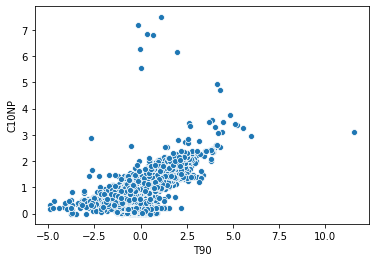

,T90,C10NP
T90,1.000000,0.626581
C10NP,0.626581,1.000000


In [10]:
sns.scatterplot(x=x_col,y=y_name,data=train)
plt.show()
train.corr().loc[[x_col,y_name],[x_col,y_name]]

# modeling

評分指標

In [0]:
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from math import sqrt
def metric(y_t,y_p):
  res = {'R2':r2_score(y_t,y_p),
         'RMSE':sqrt(mean_squared_error(y_t,y_p)),
         'mean_absolute_error':mean_absolute_error(y_t,y_p)}
  return pd.DataFrame(res,index=['score'])

In [12]:
import xgboost
from sklearn.svm import SVR
from math import sqrt
from lightgbm import LGBMRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import warnings 
warnings.simplefilter('ignore')

#選擇模型
#model = DecisionTreeRegressor(max_depth=1)
#model = xgboost.XGBRegressor(objective='reg:squarederror')
model = SVR()
#model = LinearRegression()

#交叉驗證
val_scores = cross_validate(model,train[[x_col]],train[y_name],cv=5)

#交叉驗證結果
print('交叉驗證分數:',val_scores['test_score'])
print('交叉驗證平均分數:',val_scores['test_score'].mean())

交叉驗證分數: [0.27814583 0.37320624 0.48700842 0.30926126 0.6003007 ]
交叉驗證平均分數: 0.4095844896316045


# fit & predict

In [0]:
# fit 
model.fit(train[[x_col]],train[y_name])
# predict
train['y_pred'] = model.predict(train[[x_col]])
test_170['y_pred'] = model.predict(test_170[[x_col]])
test_50['y_pred'] = model.predict(test_50[[x_col]])

# plot

data for plot

In [0]:
by_col = x_col
train_sample_point = train.sample(1000).sort_values(by = by_col)
test_170_point = test_170.sort_values(by = by_col)
test_50_point = test_50.sort_values(by = by_col)

plot function

In [0]:
def pred_plot(df,by_col):
  fig = plt.figure(figsize=(20,5))
  plt.plot(df[by_col],df['y_pred'],label='pred line',color='red')
  plt.scatter(df[by_col],df[y_name],label='data point')
  plt.xlabel(by_col)
  plt.ylabel(y_name)
  plt.legend()
  plt.show()

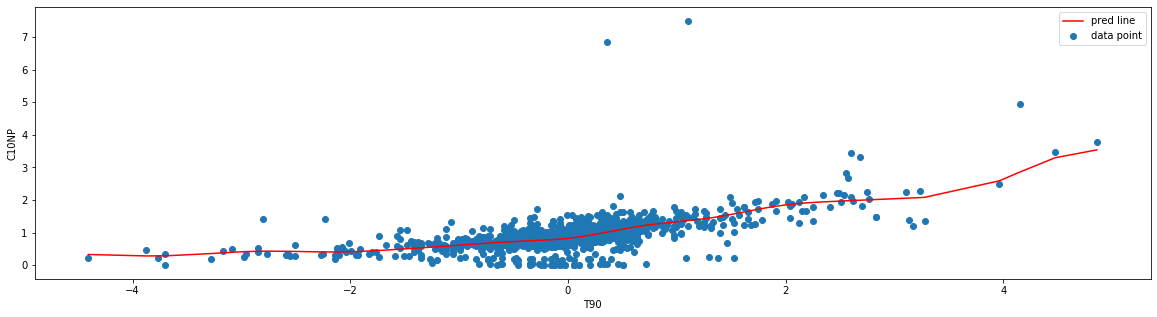

train_scores:


,R2,RMSE,mean_absolute_error
score,0.455036,0.378907,0.22202


In [16]:
pred_plot(train_sample_point,by_col)
plt.show()
print('train_scores:')
metric(train[y_name],train['y_pred'])

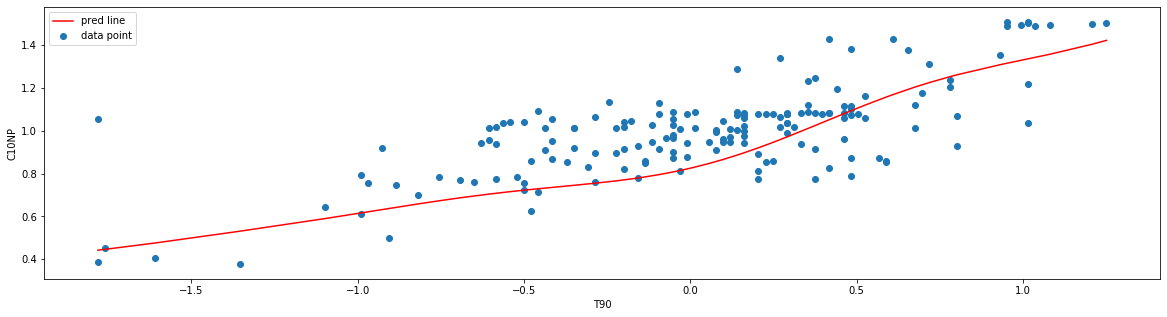

test_170_scores:


,R2,RMSE,mean_absolute_error
score,0.251416,0.182918,0.150329


In [17]:
pred_plot(test_170_point,by_col)
plt.show()
print('test_170_scores:')
metric(test_170[y_name],test_170['y_pred'])

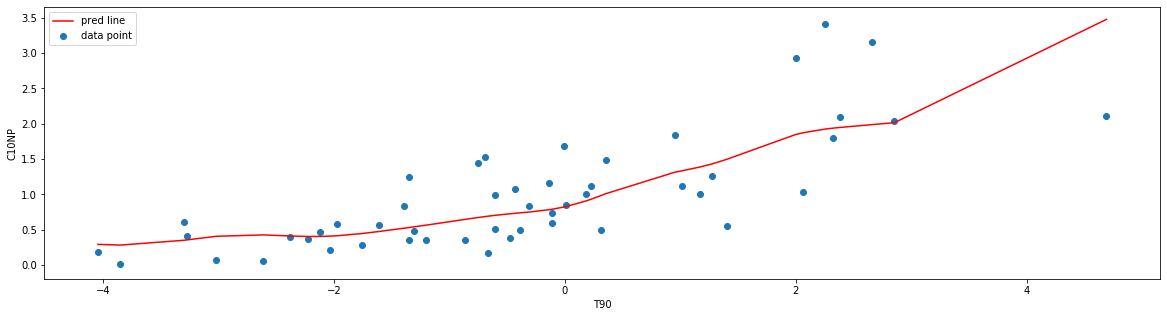

test_50_scores:


,R2,RMSE,mean_absolute_error
score,0.560401,0.519465,0.375025


In [18]:
pred_plot(test_50_point,by_col)
plt.show()
print('test_50_scores:')
metric(test_50[y_name],test_50['y_pred'])

# check outliers

In [19]:
loss = (test_170_point[y_name] - test_170_point['y_pred'])**2 # 平方誤差
loss = loss.sort_values(ascending=False)
test_170_point['out'] = False
test_170_point.loc[loss.head(5).index,'out'] = True
print(loss.head(5))

159    0.376729
109    0.161557
36     0.146992
111    0.141383
161    0.139169
dtype: float64


In [20]:
loss = (test_50_point[y_name] - test_50_point['y_pred'])**2 # 平方誤差
loss = loss.sort_values(ascending=False)
test_50_point['out'] = False
test_50_point.loc[loss.head(5).index,'out'] = True
print(loss.head(5))

175    2.207906
100    1.871832
180    1.372758
70     1.176567
170    0.892937
dtype: float64


# plot out

In [0]:
def d_out_score(df):
  df = df.loc[df['out'] == False]
  return metric(df[y_name],df['y_pred'])

In [0]:
def plot_out(df):
  fig = plt.figure(figsize=(20,5))
  out_point = df[df['out'] == True]
  plt.plot(df[by_col],df['y_pred'],label='pred line',color='red')
  plt.scatter(df[by_col],df[y_name],label='test point')
  plt.scatter(out_point[by_col],out_point[y_name],label='out point',color='orange')
  plt.xlabel(by_col)
  plt.ylabel(y_name)
  plt.legend()
  plt.show()

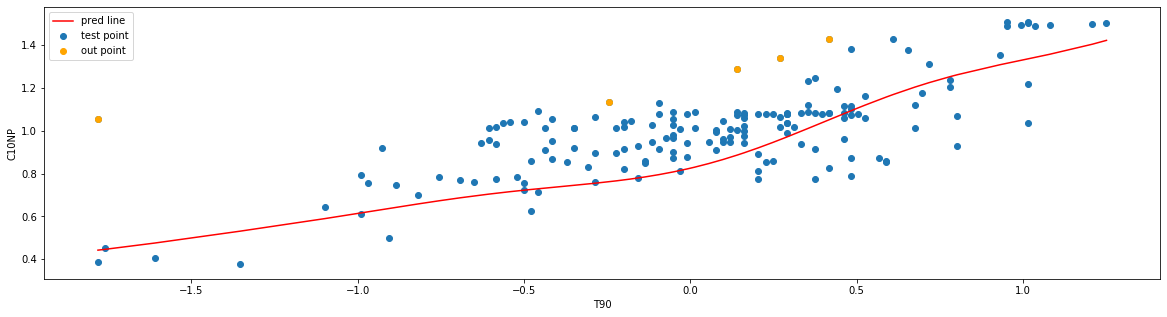

,R2,RMSE,mean_absolute_error
score,0.343259,0.169172,0.141866


In [23]:
plot_out(test_170_point)
plt.show()
d_out_score(test_170_point)

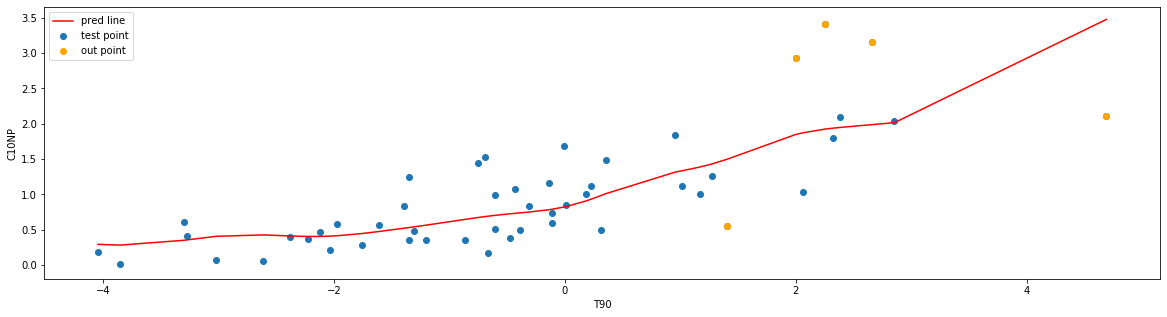

,R2,RMSE,mean_absolute_error
score,0.558431,0.36424,0.282131


In [24]:
plot_out(test_50_point)
plt.show()
d_out_score(test_50_point)